In [1]:
import torch
import torch.nn as nn
import torchvision.models as models

import glob
import tqdm
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import time
from tqdm import tqdm
import copy
from IPython.display import display, Image, clear_output

import tqdm

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

# Load stable diffusion model
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae=  pipe.vae.to(device).eval()

def decode_latents_grad(latents):
    # latents = F.interpolate(latents, (64, 64), mode='bilinear', align_corners=False)
    latents = 1 / 0.18215 * latents

    imgs = vae.decode(latents).sample

    imgs = (imgs / 2 + 0.5).clamp(0, 1)

    return imgs

def decode_latents(latents):
    # latents = F.interpolate(latents, (64, 64), mode='bilinear', align_corners=False)
    with torch.no_grad():
        with torch.amp.autocast(device):
            latents = 1 / 0.18215 * latents

            with torch.no_grad():
                imgs = vae.decode(latents).sample

            imgs = (imgs / 2 + 0.5).clamp(0, 1)

    return imgs

def encode_imgs(imgs):
    # imgs: [B, 3, H, W]
    with torch.no_grad():
        with torch.amp.autocast(device):
            imgs = 2 * imgs - 1

            posterior = vae.encode(imgs).latent_dist
            latents = posterior.sample() * 0.18215

    return latents


# import tqdm
# decoded_latents = []
# for i in tqdm.tqdm(range(5)):
#     for j in range(i*100):
#         for amp in range(1,5):
#             rnd_latent = torch.randn((1,4, 2**i, 2**i), device=device)  * amp
#             decoded_latent = decode_latents(rnd_latent)
#             decoded_latents.append(decoded_latent.cpu())
# import pickle
# with open('./dump_for_train/decoded_latents.pickle','wb') as f:
#     pickle.dump(decoded_latents, f)

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.5.1+cu121 with CUDA 1201 (you have 2.6.0+cu124)
    Python  3.12.8 (you have 3.12.2)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
cd AdversarialRendering/

/home/dcor/niskhizov/AdversarialRendering


In [4]:
import pickle

dump_dir = './dump_for_train/'


In [5]:
with open(dump_dir + 'adv_patchs.pickle','rb') as f:
    adv_patchs = pickle.load(f)
with open(dump_dir + 'frames.pickle','rb') as f:
    frames = pickle.load(f)

In [58]:

with open(dump_dir + 'orig_ref_frame.pickle','rb') as f:
    orig_ref_frame = pickle.load(f)

with open(dump_dir + 'H.pickle','rb') as f:
    H = pickle.load(f)

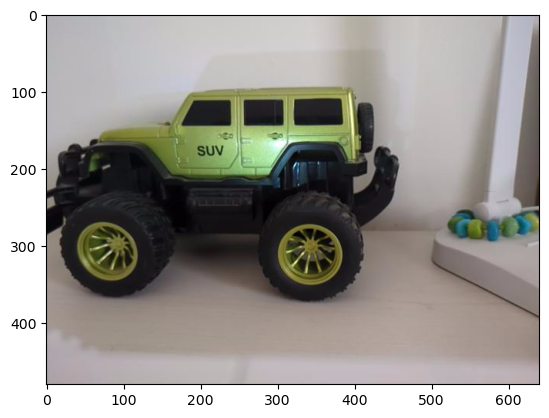

In [59]:
plt.imshow(orig_ref_frame)

In [8]:


from torchvision import transforms

tt = transforms.ToTensor()

import torch 
import kornia
H_t = torch.tensor(H).float().unsqueeze(0).cuda()
def warp(img):
    return kornia.geometry.transform.warp_perspective(img, H_t, (orig_ref_frame.shape[0], orig_ref_frame.shape[1]))

H_t_i = H_t.inverse()
def unwarp(img):
    return kornia.geometry.transform.warp_perspective(img, H_t_i , (400,800))


with open(dump_dir + 'HsSectionsBuffer.pickle','rb') as f:
    Hs,sections,buffer = pickle.load(f)

H_ts = torch.tensor(Hs).float().cuda()
def warp2(imgs):
    img_warped = []
    for img_t in imgs:
        warped_patchs = []
        for i, (start_x, start_y, end_x, end_y) in enumerate(sections):

            img_section_mask = torch.zeros((img_t.shape[1], img_t.shape[2])).cuda()
            img_section_mask[start_y+buffer:end_y-buffer, start_x+buffer:end_x-buffer] = 1
            # img_section_mask[start_y:end_y, start_x:end_x] = 1

            img_masked = img_t * torch.tensor(img_section_mask).unsqueeze(0).unsqueeze(0).float()

            warped_patch = kornia.geometry.transform.warp_perspective(img_masked, H_ts[i].unsqueeze(0), (orig_ref_frame.shape[0], orig_ref_frame.shape[1]))
            warped_patchs.append(warped_patch.squeeze(0))

        img_warped.append(torch.stack(warped_patchs, dim=0).sum(0))
        
    return torch.stack(img_warped, dim=0)


/tmp/ipykernel_1120733/4219231436.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  H_ts = torch.tensor(Hs).float().cuda()


In [9]:
# import pickle
# import datetime

# curr_without_sec = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
# curr_without_sec = curr_without_sec.replace(" ", "_")

# with open(dump_dir + f'H_t_{curr_without_sec}.pickle','wb') as f:
#     pickle.dump(H_t, f)

In [10]:
from torch import nn 
from torchvision import models
from torchvision import transforms
from PIL import Image

class LightCNN(nn.Module):
    def __init__(self):
        super(LightCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),  # 4x60x80 -> 8x60x80
            nn.LeakyReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1), # 8x60x80 -> 16x60x80
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # 8x60x80 -> 16x60x80
            nn.LeakyReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1), # 8x60x80 -> 16x60x80
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, padding=1), # 16x60x80 -> 8x60x80
            nn.LeakyReLU(),
            nn.Conv2d(8, 3, kernel_size=3, padding=1) )  # 8x60x80 -> 4x60x80
        
        # self.loss_estimator = nn.Sequential(nn.Conv2d(16, 8 ,stride=2, kernel_size=5), nn.LeakyReLU(),
        #                                      nn.Conv2d(8, 4, stride=2,kernel_size=5), nn.LeakyReLU(),
        #                                      nn.Conv2d(4, 1, stride=2,kernel_size=5), nn.LeakyReLU(),
        #                                     )
        # self.loss_final = nn.Linear(1*34*72, 1)
        # self.final_relu = nn.ReLU()


    def forward(self, x):
        x = self.encoder(x)
        # lx = self.loss_estimator(x)
        # lx = lx.view(lx.size(0), -1)
        # lx = self.final_relu(self.loss_final(lx))

        x = self.decoder(x)
        return x

In [11]:
botorch_dir = './botorch_snapshots/'
import glob
patchs = list(glob.glob(botorch_dir + '*patch.jpg', recursive=True))
aug = [x.replace('patch.jpg', 'frame_aug.jpg') for x in patchs]
# botorch_dir = './current_pairs//'
# import glob
# patchs = list(glob.glob(botorch_dir + '*adv_patch_*', recursive=True))
# aug = [x.replace('adv_patch', 'unwrapped_frame') for x in patchs]


In [12]:
aug = ['./botorch_snapshots/unwrapped_frame_mug_27_4_{}.jpg'.format(i) for i in range(0, len(patchs))]

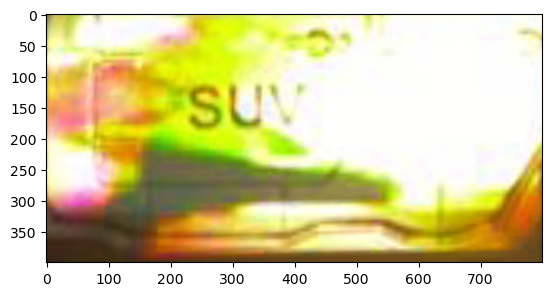

In [13]:
plt.imshow(cv2.imread('./current_pairs/unwrapped_frame_244.jpg'))

In [5]:
unwrapped_frames = []

for frame in tqdm.tqdm(frames):
    frame_tensor = torch.tensor(frame).permute(2,0,1).float().cuda().unsqueeze(0) / 255
    unwrapped_frame = unwarp(frame_tensor).squeeze(0).cpu()
    unwrapped_frames.append(unwrapped_frame)



NameError: name 'frames' is not defined

In [14]:
# for i in range(0,4000,100):
#     plt.imshow(unwrapped_frames[i].permute(1,2,0).numpy())
#     plt.show()
#     plt.imshow(adv_patchs[i].float().permute(1,2,0).numpy())
#     plt.show()
#     print('#######################################################')

In [15]:
ds = list(zip(patchs, aug))

In [16]:
ds[0]

('./botorch_snapshots/04-05_21_30_34_patch.jpg',
 './botorch_snapshots/unwrapped_frame_mug_27_4_0.jpg')

In [17]:
# torch train test split
tt = transforms.ToTensor()
from torch.utils.data import DataLoader, random_split, Dataset
class CustomDataset(Dataset):
    def __init__(self, data):
        data = [(x[0], x[1]) for x in data if os.path.exists(x[0]) and os.path.exists(x[1])]
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        adv_patch, unwrapped_frame = self.data[idx]
        adv_patch = cv2.imread(adv_patch, cv2.IMREAD_COLOR)
        adv_patch = tt(cv2.cvtColor(adv_patch, cv2.COLOR_BGR2RGB))
        unwrapped_frame = cv2.imread(unwrapped_frame, cv2.IMREAD_COLOR)
        unwrapped_frame = tt(cv2.cvtColor(unwrapped_frame, cv2.COLOR_BGR2RGB))

        return adv_patch, unwrapped_frame
    
dataset = CustomDataset(ds)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)


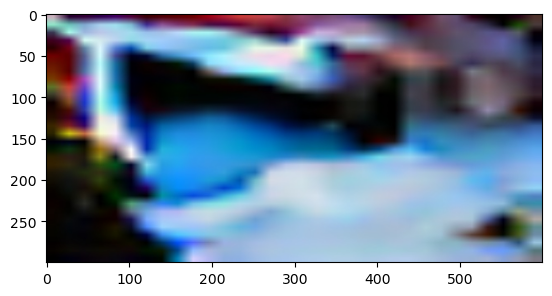

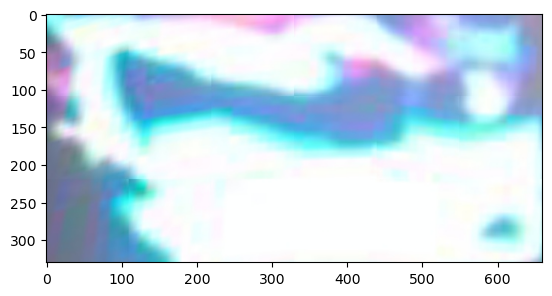

In [18]:
idx = 6000
plt.imshow(dataset[idx][0].permute(1,2,0).numpy())
plt.show()
plt.imshow(dataset[idx][1].permute(1,2,0).numpy())
plt.show()

In [19]:
mapper = LightCNN().cuda()#LightCNN().cuda()


In [20]:
mapper.load_state_dict(torch.load('dump_for_train/mapper_2025-04-22_23:00.pth'))

<All keys matched successfully>

In [21]:
mapper_opt = torch.optim.AdamW(mapper.parameters(), lr=0.001)
mapper.train()

LightCNN(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [22]:
import torchvision
resizer =  torchvision.transforms.Resize((330, 660))

L1 = nn.L1Loss()
for epoch in tqdm.tqdm_notebook(range(1000)):
    train_loss = 0
    for i, (s, f) in enumerate(train_loader):
        s = resizer(s).cuda().float()
        f = f.cuda().float()
        mapper_opt.zero_grad()
        pred = mapper(s.squeeze(1))
        loss = L1(pred, f.squeeze(1))
        # lossloss = (lx - loss).pow(2).mean()
        # loss += lossloss
        loss.backward()
        mapper_opt.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")

    if epoch % 10 == 0:
        with torch.no_grad():
            test_loss = 0
            for i, (s, f) in enumerate(test_loader):
                s_test = resizer(s).cuda().float()
                f_test = f.cuda().float()
                pred_test = mapper(s_test.squeeze(1))
                loss = L1(pred_test, f_test.squeeze(1))
                test_loss += loss.item()
            test_loss /= len(test_loader)
        
            print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}")
        



/tmp/ipykernel_1120733/3765778625.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.0432
Epoch 1, Test Loss: 0.0416
Epoch 2, Train Loss: 0.0417
Epoch 3, Train Loss: 0.0414
Epoch 4, Train Loss: 0.0412
Epoch 5, Train Loss: 0.0411
Epoch 6, Train Loss: 0.0410
Epoch 7, Train Loss: 0.0410
Epoch 8, Train Loss: 0.0407
Epoch 9, Train Loss: 0.0408
Epoch 10, Train Loss: 0.0407
Epoch 11, Train Loss: 0.0406
Epoch 11, Test Loss: 0.0404
Epoch 12, Train Loss: 0.0407
Epoch 13, Train Loss: 0.0406
Epoch 14, Train Loss: 0.0406
Epoch 15, Train Loss: 0.0406
Epoch 16, Train Loss: 0.0405
Epoch 17, Train Loss: 0.0405
Epoch 18, Train Loss: 0.0404
Epoch 19, Train Loss: 0.0405
Epoch 20, Train Loss: 0.0404


KeyboardInterrupt: 

In [2]:
mapper

NameError: name 'mapper' is not defined

In [203]:
with torch.no_grad():
        test_loss = 0
        for i, (s, f) in enumerate(test_loader):
            s_test = resizer(s).cuda().float()
            f_test = f.cuda().float()
            pred_test = mapper(s_test.squeeze(1))
            loss = L1(pred_test, f_test.squeeze(1))
            test_loss += loss.item()
            break
        test_loss /= len(test_loader)
    
        print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}")

Epoch 7, Test Loss: 0.0016


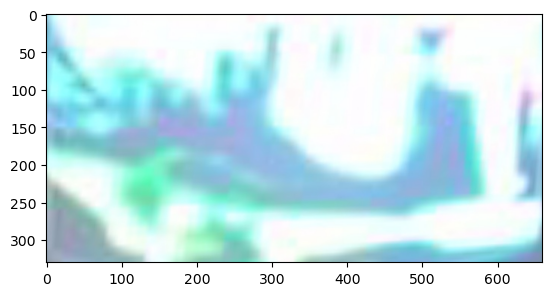

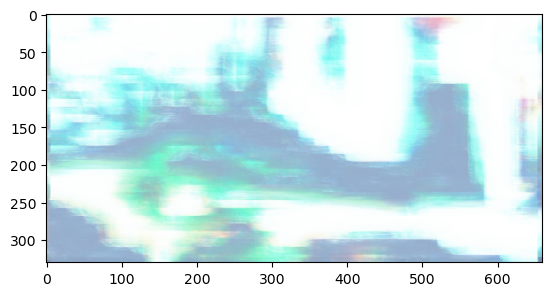

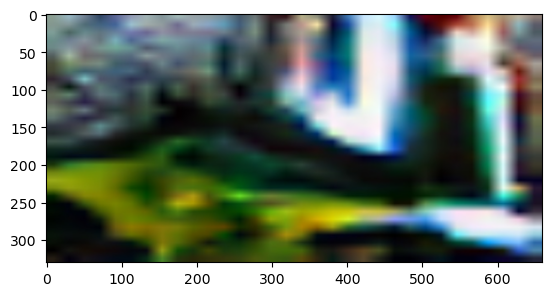

In [67]:
idx = 14
plt.imshow(f_test[idx].cpu().detach().permute(1,2,0).numpy())
plt.show()
plt.imshow(pred_test[idx].cpu().detach().permute(1,2,0).numpy())
plt.show()
plt.imshow(s_test[idx].cpu().detach().permute(1,2,0).numpy())
plt.show()


In [135]:
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift
from skimage.feature import hog

In [144]:
def to_grayscale(img_tensor):
    img_np = img_tensor.numpy()
    # Convert to grayscale using RGB weights
    gray = 0.2989 * img_np[0] + 0.5870 * img_np[1] + 0.1140 * img_np[2]
    return gray

def compute_hog(gray_img):
    hog_features, hog_image = hog(
        gray_img, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
        visualize=True, feature_vector=False, channel_axis=None
    )
    return hog_image  # visualization image is 2D


In [171]:
idx=1
image1, image2 = s[idx].cpu(), f[idx].cpu()
# image1 = image1.permute(1,2,0).numpy()
# image2 = image2.permute(1,2,0).numpy()
image1 = to_grayscale(image1)
image2 = to_grayscale(image2)

image1 = compute_hog(image1)
image2 = compute_hog(image2)

shift_estimate, error, diffphase = phase_cross_correlation(image1,image2 , upsample_factor=1)
print(shift_estimate, error, diffphase)

[-8.  0.] 0.9999776346166548 1.7495788e-09


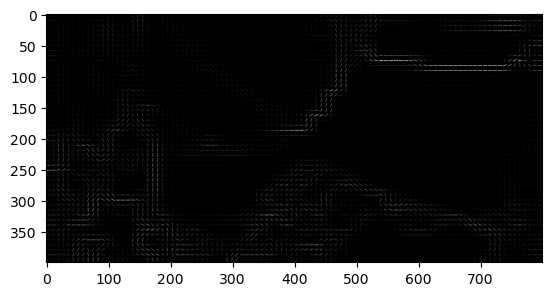

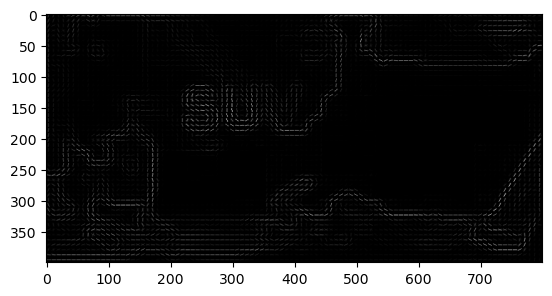

In [172]:
plt.imshow(image1, cmap='gray')
plt.show()
plt.imshow(image2, cmap='gray')
plt.show()

In [163]:
shift_estimate

array([-8.,  0.], dtype=float32)

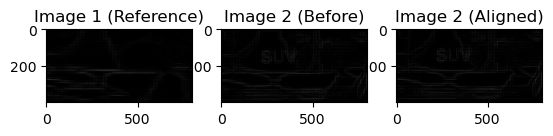

In [164]:
aligned_image2 = shift(image2, shift=shift_estimate)

# Optional: visualize
plt.subplot(1, 3, 1)
plt.title("Image 1 (Reference)")
plt.imshow(image1, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Image 2 (Before)")
plt.imshow(image2, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Image 2 (Aligned)")
plt.imshow(aligned_image2, cmap='gray')

plt.show()

In [30]:
from torch.nn import MSELoss

In [31]:
with torch.no_grad():
    test_loss = 0
    for i, (s, f) in enumerate(test_loader):
        s_test = s.cuda().float()
        f_test = f.cuda().float()
        pred_test = mapper(s_test.squeeze(1))
        loss = (pred_test - f_test.squeeze(1)).pow(2).sum() / f_test.flatten(1).shape[1]
        test_loss += loss / test_size


In [32]:
tds = list(test_dataset)

In [33]:
print(torch.stack([x[0] for x in tds]).std())
print(torch.stack([x[1] for x in tds]).std())
print(torch.sqrt(test_loss))

tensor(0.2831)
tensor(0.3297)
tensor(0.2908, device='cuda:0')


In [57]:
# save the model
import datetime
curr_without_sec = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
curr_without_sec = curr_without_sec.replace(" ", "_")
torch.save(mapper.state_dict(), f'./dump_for_train/mapper_mug_{curr_without_sec}.pth')

In [ ]:
plt.imshow(s_test[0].detach().cpu().float().numpy().transpose(1,2,0))
plt.show()
plt.imshow(f_test[0].detach().cpu().float().numpy().transpose(1,2,0))
plt.show()
plt.imshow(pred_test[0].detach().cpu().float().numpy().transpose(1,2,0))
plt.show()
diff = pred_test[0].detach().cpu().float().numpy().transpose(1,2,0) - f_test[0].detach().cpu().float().numpy().transpose(1,2,0)
# plt.imshow(diff)
# add color scale bar
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar

diff = np.abs(diff)

fig, ax = plt.subplots()
cax = ax.imshow(diff, cmap='hot')
cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('Color Scale')
plt.show()

In [ ]:
from torch import nn 
from torchvision import models
from torchvision import transforms
from PIL import Image

class LightCNN2(nn.Module):
    def __init__(self):
        super(LightCNN2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=3, padding=1),  # 4x60x80 -> 8x60x80
            nn.LeakyReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1), # 8x60x80 -> 16x60x80
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # 8x60x80 -> 16x60x80
            nn.LeakyReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1), # 8x60x80 -> 16x60x80
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, padding=1), # 16x60x80 -> 8x60x80
            nn.LeakyReLU(),
            nn.Conv2d(8, 4, kernel_size=3, padding=1) )  # 8x60x80 -> 4x60x80

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
import torchvision
de_resizer = torchvision.transforms.Resize((32,32))
resizer = torchvision.transforms.Resize((400,800))

In [ ]:
mapper_latent = LightCNN2().cuda()#LightCNN().cuda()
mapper_latent_opt = torch.optim.AdamW(mapper_latent.parameters(), lr=0.001)

In [ ]:
L1 = nn.L1Loss()
for epoch in tqdm.tqdm(range(1000)):
    train_loss = 0
    for i, (s, f) in enumerate(train_loader):
        s = s.cuda().float()
        f = f.cuda().float()
        
        s = encode_imgs(de_resizer(s))
        f = encode_imgs(de_resizer(f))

        mapper_latent_opt.zero_grad()
        pred = mapper_latent(s.squeeze(1))
        loss = L1(pred, f.squeeze(1))
        # lossloss = (lx - loss).pow(2).mean()
        # loss += lossloss
        loss.backward()
        mapper_latent_opt.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")

    if epoch % 10 == 0:
        with torch.no_grad():
            test_loss = 0
            for i, (s, f) in enumerate(test_loader):
                s_test = s.cuda().float()
                f_test = f.cuda().float()

                s_test = encode_imgs(de_resizer(s_test))
                f_test = encode_imgs(de_resizer(f_test))


                pred_test = mapper_latent(s_test.squeeze(1))
                loss = L1(pred_test, f_test.squeeze(1))
                test_loss += loss.item()
            test_loss /= len(test_loader)
        
            print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}")
        



In [ ]:
with torch.no_grad():
    test_loss = 0
    for i, (s, f) in enumerate(test_loader):
        s_test = s.cuda().float()
        f_test = f.cuda().float()

        s_test = encode_imgs(de_resizer(s_test))
        f_test = encode_imgs(de_resizer(f_test))

        pred_test = mapper_latent(s_test.squeeze(1))
        loss = (resizer(decode_latents(pred_test).float()) - resizer(decode_latents(f_test).float())).pow(2).sum() / f_test.flatten(1).shape[1]
        test_loss += loss / test_size


In [ ]:
print(torch.stack([x[0] for x in tds]).std())
print(torch.stack([x[1] for x in tds]).std())
print(torch.sqrt(test_loss))

In [ ]:
idx = 0
plt.imshow(resizer(decode_latents(s_test[idx].unsqueeze(0)).float()).squeeze(0).permute(1,2,0).cpu().numpy())
plt.show()
plt.imshow(resizer(decode_latents(f_test[idx].unsqueeze(0)).float()).squeeze(0).permute(1,2,0).cpu().numpy())
plt.show()
plt.imshow(resizer(decode_latents(pred_test[idx].unsqueeze(0)).float()).squeeze(0).permute(1,2,0).cpu().numpy())
plt.show()



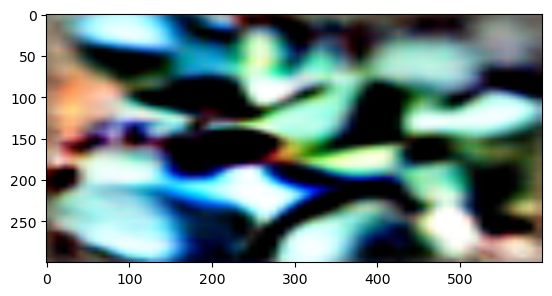

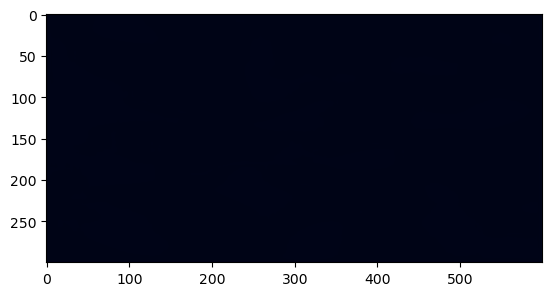

In [39]:
rnd_latent = torch.randn((1,4, 8, 8), device=device) 
decoded_latent = resizer(decode_latents(rnd_latent)) 
pred_test = mapper(decoded_latent.float())
plt.imshow(decoded_latent[0].detach().cpu().float().numpy().transpose(1,2,0))
plt.show()
plt.imshow(pred_test[0].detach().cpu().float().numpy().transpose(1,2,0))    
plt.show()


# patch train

In [23]:
import torchvision
device = 'cuda'
latent = (torch.rand((8,4, 4, 4), device=device) - 0.5) * 2
# latent = torch.load('./dump_for_train/working_latent_2025-04-18_14:00.pth')
latent.requires_grad = True

resizer = torchvision.transforms.Resize((400, 800))

# latent = torch.rand((1,3, 10, 20), device=device) / 2
# latent.requires_grad = True

lbfgs_latent_opt = torch.optim.LBFGS([latent], lr=0.01, max_iter=10)
# latent_opt = torch.optim.Adam([latent], lr=0.001)

In [24]:
import sys
sys.path.insert(0, '/home/dcor/niskhizov//AdversarialRendering/utils')
from classfier import *

In [14]:
mapper = LightCNN().cuda()#LightCNN().cuda()
mapper.load_state_dict(torch.load(f'./dump_for_train/mapper_2025-04-18_14:13.pth'))

<All keys matched successfully>

In [38]:
ref_tensor = torch.tensor(orig_ref_frame).permute(2,0,1).float().cuda() / 255
# ref_tensor = frame_tensor

In [39]:


# def latent_closure_adp():
#     # with torch.amp.autocast(device):
#     lbfgs_latent_opt.zero_grad()

#     # latent_normalized = latent - latent.mean()
#     # latent_normalized = latent_normalized / latent_normalized.std()

#     d = decode_latents_grad(latent).float()

#     adv_patch = resizer(d)

#     adv_patch = mapper(adv_patch)

#     w_mask  =warp(adv_patch*0+1)
#     w  =warp(adv_patch)

#     sum_tensor =  ((w_mask != 0) * -1 + 1) * ref_tensor + w * 1#((w_mask != 0) * -0.5 + 1) * ref_tensor + w * 0.5

#     sum_tensor = sum_tensor #+ torch.randn_like(sum_tensor.cuda()) * 0.1

#     adv_loss = adv_loss_calc(sum_tensor) #+ adv_patch.norm() / 10000

#     adv_loss.backward()

#     return adv_loss

In [27]:
latent_opt = torch.optim.Adam([latent], lr=0.1)

In [28]:
import torchvision.transforms as T

jitter = T.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1)
jitter_total_photo = T.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1)
jitter_with_hue = T.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.1)

In [29]:
batch_size = 1
orig_clases = torch.tensor([504,968, 470]).cuda()
total_clases_without_orig = torch.tensor([x for x in list(range(0, 1000)) if x not in orig_clases]).cuda()


# def adv_loss_calc(image):
#     adv_loss = 0
#     pred = resnet_predict_raw(image)
#     for p in pred:
#       adv_loss += torch.stack([100*p.softmax(0)[c.item()] for c in orig_clases]).mean() / pred.shape[0]
#     return adv_loss

def adv_loss_calc(image):
    assert len(image.shape) == 4, "Image should be of shape (batch_size, 3, h, w)"
    adv_loss = []
    pred = resnet_predict_raw(image)
    for p in pred:
      adv_loss.append(p[orig_clases].mean())
    return torch.stack(adv_loss)



def adv_loss_calc2(image):
    adv_loss = []
    pred = resnet_predict_raw(image)
    for p in pred:
      forbiden = p[orig_clases].max()
      allowed = p[total_clases_without_orig].max()
      adv_loss.append(forbiden - allowed)
    return torch.stack(adv_loss)

In [42]:
resizer = torchvision.transforms.Resize((330, 660))

# blend_ratio = 1
for i in tqdm.tqdm_notebook(range(10000)):
    # adv_loss = lbfgs_latent_opt.step(latent_closure_adp)

    blend_ratio = torch.rand(1).cuda() * 0.5 + 0.5
    if i < 100:
        jitter = lambda x: x
    else:
        jitter = T.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1)
        
    latent_opt.zero_grad()
    d = decode_latents_grad(latent).float()

    adv_patch = resizer(d)

    adv_patch_m = jitter(mapper(adv_patch))

    # w_mask  =warp(adv_patch_m*0+1)
    # w  =warp(adv_patch_m)
    w_mask  =warp2(adv_patch_m*0+1)
    w  =warp2(adv_patch_m)

    sum_tensor = jitter_total_photo(((w_mask != 0) * -blend_ratio + 1) * ref_tensor + w *blend_ratio)

    adv_loss = adv_loss_calc2(sum_tensor).mean() #+ adv_patch.norm() / 10000
    
    adv_loss.backward()

    if i % 1 == 0:
        latent_opt.step()

    if i % 100 == 0:
        # print(f"Iteration {i}, Loss: {latent_closure_adp().item():.4f}")
        print(f"Iteration {i}, Loss: {adv_loss.item():.4f}. grad_norm: {latent.grad.norm().item():.4f}")

        with torch.no_grad():
            d = decode_latents(latent).float()
            adv_patch = resizer(d)
            adv_patch_m = jitter(mapper(adv_patch))

            # w_mask  =warp(adv_patch_m*0+1)
            # w  =warp(adv_patch_m)
            w_mask  =warp2(adv_patch_m*0+1)
            w  =warp2(adv_patch_m)

            blend_ratio = torch.rand(1).cuda() * 0.5 + 0.5

            sum_tensor =  jitter_total_photo(((w_mask != 0) * -blend_ratio + 1) * ref_tensor + w * blend_ratio)##((w_mask != 0) * -0.5 + 1) * ref_tensor + w * 0.5
            
            adv_loss = adv_loss_calc2(sum_tensor)

            sum_tensor = sum_tensor.cpu()
            argmin = torch.argmin(adv_loss).cpu().item()

            plt.imshow(sum_tensor[argmin].permute(1,2,0).numpy())
            plt.show()
            print(resnet_predict(sum_tensor[argmin].unsqueeze(0).cuda()))

            test_pred = resnet_predict(sum_tensor.cuda())
            if type(test_pred) == list:
                print(np.unique(resnet_predict(sum_tensor.cuda()),return_counts=True))
            # print(lx)

/tmp/ipykernel_1120733/3190283150.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(10000)):


  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_1120733/4219231436.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_masked = img_t * torch.tensor(img_section_mask).unsqueeze(0).unsqueeze(0).float()


OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB. GPU 0 has a total capacity of 10.75 GiB of which 12.69 MiB is free. Including non-PyTorch memory, this process has 10.73 GiB memory in use. Of the allocated memory 9.64 GiB is allocated by PyTorch, and 869.67 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

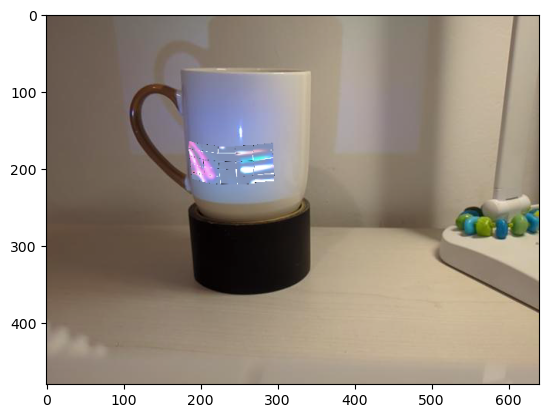

In [52]:
plt.imshow(sum_tensor[argmin].detach().cpu().permute(1,2,0).numpy())

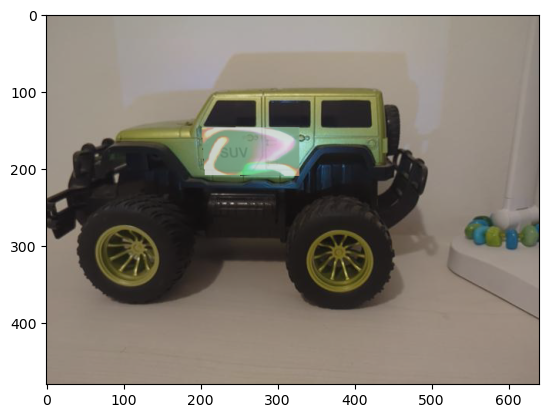

golfcart: 0.129%


In [188]:
resizer = torchvision.transforms.Resize((330, 660))
with torch.no_grad():
    d = decode_latents(latent).float()
    adv_patch = resizer(d)
    adv_patch_m = jitter(mapper(adv_patch))

    w_mask  =warp(adv_patch_m*0+1)
    w  =warp(adv_patch_m)

    sum_tensor =  jitter_total_photo(((w_mask != 0) * -blend_ratio + 1) * ref_tensor + w * blend_ratio)##((w_mask != 0) * -0.5 + 1) * ref_tensor + w * 0.5
    
    adv_loss = adv_loss_calc2(sum_tensor)

    sum_tensor = sum_tensor.cpu()
    argmin = torch.argmin(adv_loss).cpu().item()

    plt.imshow(sum_tensor[argmin].permute(1,2,0).numpy())
    plt.show()
    print(resnet_predict(sum_tensor[argmin].unsqueeze(0).cuda()))

In [ ]:
del pred

In [ ]:
torch.cuda.empty_cache()

In [ ]:
817 in orig_clases

In [ ]:
resnet_predict(image)[25]

In [ ]:
torch.argmin(torch.stack(adv_loss))

In [ ]:
argmin

In [ ]:

def adv_loss_calc(image):
    assert len(image.shape) == 4, "Image should be of shape (batch_size, 3, h, w)"
    adv_loss = []
    pred = resnet_predict_raw(image)
    for p in pred:
      adv_loss.append(torch.stack([p[c.item()] for c in orig_clases]).mean())
    return torch.stack(adv_loss)

In [ ]:
 adv_loss_calc(sum_tensor).cuda()

In [209]:
# save latent
import datetime
curr_without_sec = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
curr_without_sec = curr_without_sec.replace(" ", "_")
torch.save(latent.detach(), f'./dump_for_train/working_latent_{curr_without_sec}.pth')


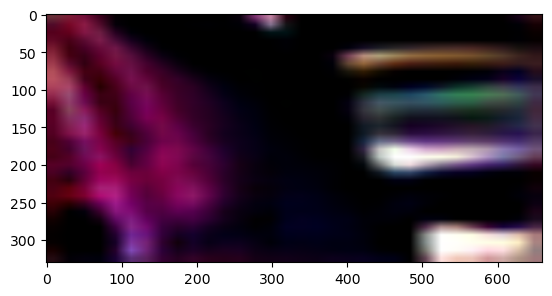

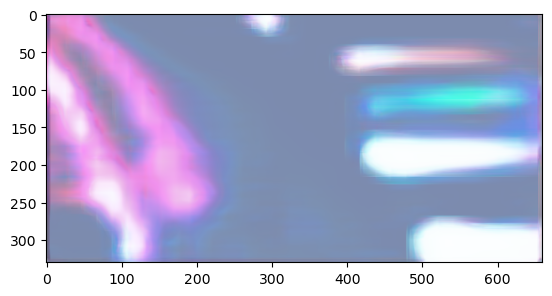

In [56]:
idx = argmin
plt.imshow(adv_patch[argmin].cpu().detach().permute(1,2,0).numpy())
plt.show()
plt.imshow(adv_patch_m[argmin].cpu().detach().permute(1,2,0).numpy())
plt.show()

In [ ]:
plt.imshow(jitter(adv_patch_m)[idx].cpu().detach().permute(1,2,0).numpy())

In [ ]:
jitter_total_photo = T.ColorJitter(brightness=0.3,contrast=0.3,saturation=0.3)
plt.imshow(jitter_total_photo(sum_tensor)[idx].cpu().detach().permute(1,2,0).numpy())

In [ ]:
inp = sum_tensor.cuda()+torch.randn_like(sum_tensor.cuda()) * 0.01

resnet_predict(inp)


In [ ]:
plt.imshow(inp[0].detach().cpu().permute(1,2,0).numpy())

In [ ]:
# load patches/frame.png
frame = cv2.imread('./patches/frame.png')
frame_tensor = torch.tensor(frame).permute(2,0,1).float().cuda() / 255

In [ ]:

with torch.no_grad():
    d = decode_latents(latent).float()
    adv_patch = resizer(d)
    adv_patch_m = mapper(adv_patch)

    w_mask  =warp(adv_patch_m*0+1)
    w  =warp(adv_patch_m)

    sum_tensor =  ((w_mask != 0) * -1 + 1) * ref_tensor + w * 1##((w_mask != 0) * -0.5 + 1) * ref_tensor + w * 0.5
    sum_tensor = sum_tensor.cpu()

    plt.imshow(sum_tensor[0].permute(1,2,0).numpy())

    plt.show()
    print(resnet_predict(sum_tensor.cuda()))
    # print(lx)

In [ ]:
with torch.no_grad():
    adv_patch_m = mapper(adv_patch)
w_mask  =warp(adv_patch_m*0+1)
w  =warp(adv_patch_m)
sum_tensor =  ((w_mask != 0) * -1 + 1) * frame_tensor + w * 1

In [ ]:
resnet_predict(sum_tensor.cuda())

In [ ]:
plt.imshow(sum_tensor[0].detach().permute(1,2,0).cpu().numpy())

In [ ]:
plt.imshow(frame)

In [ ]:
print(resnet_predict(inp))

In [ ]:
plt.imshow(adv_patch[0].detach().cpu().permute(1,2,0).numpy())

In [ ]:
resizer = torchvision.transforms.Resize((300, 600))

In [ ]:
a = resizer(torch.randn(1,3,10,10))

In [ ]:
mapper(a.cuda())[1]

In [ ]:
plt.imshow(a[0].permute(1,2,0).numpy())

In [ ]:
mapper(adv_patch*0+1)[1]

In [55]:
idx = argmin
cv2.imwrite('./patches/out_28_4_3.png', (adv_patch[idx].detach().cpu().permute(1,2,0).numpy()*255).astype(np.uint8))
cv2.imwrite('./patches/out_28_4_m_3.png', (adv_patch_m[idx].clamp(0,1).detach().cpu().permute(1,2,0).numpy()*255).astype(np.uint8))


True

In [ ]:
plt.imshow(adv_patch[0].detach().cpu().permute(1,2,0).numpy())

In [ ]:
plt.imshow(adv_patch_m[0].detach().cpu().permute(1,2,0).numpy())

In [ ]:
import cv2

In [ ]:
cv2.imshow('sum_tensor', sum_tensor[0].permute(1,2,0).numpy() * 255)

In [ ]:
plt.imshow(adv_patch[0].permute(1,2,0).cpu().numpy())

In [ ]:
plt.imshow(adv_patch_m[0].permute(1,2,0).cpu().numpy())

In [ ]:
plt.imshow(adv_patch_m[0].permute(1,2,0).cpu().numpy())